In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Obtener el número de núcleos lógicos a usar
nucleos = max(1, os.cpu_count() - 1)

print(f"Número de núcleos a usar: {nucleos}")

Número de núcleos a usar: 19


In [54]:
# Cargar los datos
df = pd.read_csv('../data/BasePFLD.csv', index_col=0).dropna() / 100

# Identificar columnas numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Normalizar las columnas numéricas
# df[columnas_numericas] = StandardScaler().fit_transform(df[columnas_numericas])

display(df)

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,SumReR,RSR,AAR,SendingNumR,ReceivingNumR,StateOpeR,StateResR,MunOpeR,MunResR,CountryR
0,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.65,0.65,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
1,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.85,0.85,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
2,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.85,0.65,0.9,0.80,0.80,0.9,0.8,1.00,0.90,1.0
3,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.85,0.85,0.9,0.80,0.80,0.9,0.8,1.00,0.90,1.0
4,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.65,0.85,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.05,0.1,0.20,0.20,0.2,0.2,0.15,0.05,0.1
26747,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.25,0.1,0.20,0.05,0.3,0.1,0.15,0.05,0.1
26748,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.25,0.25,0.3,0.05,0.05,0.2,0.2,0.15,0.05,0.1
26749,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.25,0.1,0.05,0.05,0.3,0.2,0.15,0.05,0.1


In [20]:
# Función para calcular métricas de agrupamiento
def calcular_metricas(df, clustering_func, *params):
    """Calcula métricas de agrupamiento para un algoritmo dado.

    Args:
        df (pd.DataFrame): Conjunto de datos por agrupar.
        clustering_func (callable): Función crea el modelo de agrupamiento.
        *params: Parámetros a pasar a la función de agrupamiento.
    
    Returns:
        tuple: Coeficiente de silueta e índice de Davies-Bouldin (o None si no hay grupos válidos).
    """
    # Crear y ajustar el modelo de agrupamiento
    if clustering_func == DBSCAN:
        model = clustering_func(eps=params[0], min_samples=params[1])
    elif clustering_func == AgglomerativeClustering:
        model = clustering_func(n_clusters=params[0], linkage=params[1], metric=params[2])
    elif clustering_func == GaussianMixture:
        model = clustering_func(n_components=params[0], covariance_type=params[1])
    elif clustering_func == MeanShift:
        model = clustering_func(bandwidth=params[0])
    else:
        model = clustering_func(*params)
    
    # Ajustar el modelo y predecir las etiquetas
    labels = model.fit_predict(df)

    # Si hay más de un grupo, calcular las métricas
    if len(set(labels)) > 1:
        return (params, silhouette_score(df, labels), davies_bouldin_score(df, labels))
    return (params, None, None)

# Función para ejecutar evaluaciones de parámetros de agrupamiento
def evaluar_parametros(df, clustering_func, param_grid):
    """Evalúa diferentes configuraciones de parámetros para el agrupamiento."""
    return Parallel(n_jobs=nucleos)(
        delayed(calcular_metricas)(df, clustering_func, *params) for params in param_grid
    )

# Función para graficar métricas
def graficar_metricas(params, metric_1, metric_2, labels=("Parámetro", "Métrica 1", "Métrica 2")):
    """Grafica métricas de agrupamiento."""
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Gráfica de la primera métrica
    ax1.plot(params, metric_1, marker='o', color='darkred', label=labels[1])
    ax1.set_xlabel(labels[0], color='black')
    ax1.set_ylabel(labels[1], color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')
    ax1.tick_params(axis='x', labelcolor='black')
    plt.xticks(rotation=45, ha='right')

    # Gráfica de la segunda métrica
    ax2 = ax1.twinx()
    ax2.plot(params, metric_2, marker='o', color='black', label=labels[2])
    ax2.set_ylabel(labels[2], color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'{labels[1]} e {labels[2]} por {labels[0]}', color='black')
    fig.tight_layout()
    display(plt)

def evaluar_agrupamiento(df, clustering_func, param_grid, metodo='silhouette'):
    """
    Evaluar un algoritmo de agrupamiento con diferentes configuraciones de parámetros y calcular métricas.

    Args:
        df (pd.DataFrame): Datos por agrupar.
        clustering_func (callable): Función del algoritmo de agrupamiento.
        param_grid (list): Lista de combinaciones de parámetros por probar.
        metodo (str): Método para el cálculo de la métrica, 'silhouette' o 'davies_bouldin'.
    
    Returns:
        pd.DataFrame: DataFrame con los resultados ordenados.
    """
    # Evaluar las combinaciones de parámetros
    resultados = evaluar_parametros(df, clustering_func, param_grid)
    
    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame(resultados, columns=['Configuración', 'Coeficiente de silueta', 'Índice de Davies-Bouldin']).dropna(subset=['Coeficiente de silueta', 'Índice de Davies-Bouldin'])

    # Ordenar los resultados por métrica
    if metodo == 'silhouette':
        resultados_df = resultados_df.sort_values(by='Coeficiente de silueta', ascending=False)
    elif metodo == 'davies_bouldin':
        resultados_df = resultados_df.sort_values(by='Índice de Davies-Bouldin')
    
    # Graficar los resultados
    graficar_metricas(
        [str(param) for param in resultados_df['Configuración']], 
        resultados_df['Coeficiente de silueta'], 
        resultados_df['Índice de Davies-Bouldin'],
        labels=("Configuración", "Coeficiente de silueta", "Índice de Davies-Bouldin")
    )

    # Devolver un DataFrame con los resultados ordenados
    return resultados_df

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
1,3,0.571550,0.714914
0,2,0.562262,0.708483
2,4,0.547943,0.877117
3,5,0.522155,0.933036
5,7,0.482131,0.963593
4,6,0.472491,0.983027
8,10,0.458180,1.007058
6,8,0.457694,0.960761
7,9,0.240082,1.455695


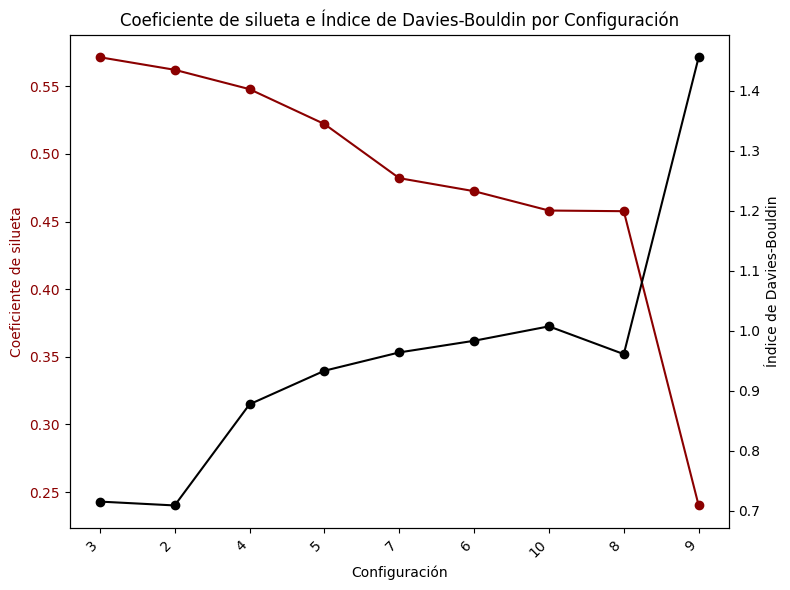

In [102]:
param_grid_kmeans = [(k,) for k in range(2, 11)]
resultados_kmeans = evaluar_agrupamiento(df, KMeans, param_grid_kmeans, metodo='silhouette')
display(resultados_kmeans)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
11,"(3.0, 15)",0.536190,0.548893
9,"(3.0, 5)",0.536190,0.548893
10,"(3.0, 10)",0.536190,0.548893
3,"(2.0, 5)",0.497843,1.003029
5,"(2.0, 15)",0.495567,1.170255
4,"(2.0, 10)",0.494126,1.064436
1,"(1.5, 10)",0.437756,1.260401
2,"(1.5, 15)",0.435021,1.402871
0,"(1.5, 5)",0.426601,1.407875
6,"(2.5, 5)",0.273689,0.870449


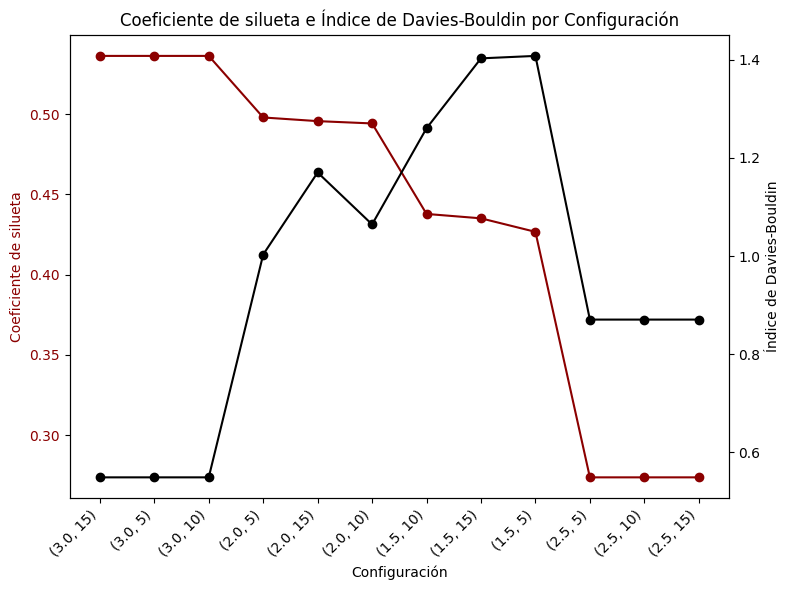

In [105]:
eps_values = [1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 15]

dbscan_funcs = [
    partial(DBSCAN, eps=eps, min_samples=min_samples)
    for eps in eps_values for min_samples in min_samples_values
]

resultados_dbscan = evaluar_parametros(df, dbscan_funcs)
display(resultados_dbscan)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
1,"(3, average, euclidean)",0.572314,0.679198
5,"(3, average, l2)",0.572314,0.679198
0,"(3, ward, euclidean)",0.571894,0.679161
2,"(3, average, manhattan)",0.568090,0.746848
4,"(3, average, l1)",0.568090,0.746848
8,"(3, single, cosine)",0.536334,0.936244
7,"(3, single, manhattan)",0.474680,0.741188
9,"(3, single, l1)",0.474680,0.741188
3,"(3, average, cosine)",0.407952,0.836820
6,"(3, single, euclidean)",0.393195,0.739527


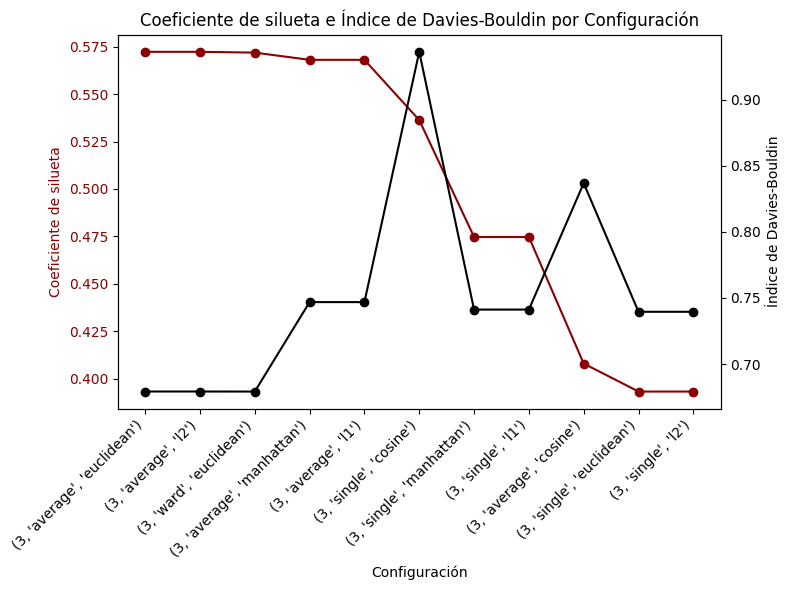

In [ ]:
n_clusters_values = [2, 3, 4, 5, 6]
linkage_values = ['ward', 'complete', 'average', 'single']
affinity_values = ['euclidean', 'manhattan', 'cosine']

param_grid_agglomerative = [
    (n_clusters, linkage, affinity)
    for n_clusters in n_clusters_values
    for linkage in linkage_values
    for affinity in (affinity_values if linkage != 'ward' else ['euclidean'])
]

resultados_agglomerative = evaluar_agrupamiento(df, AgglomerativeClustering, param_grid_agglomerative, metodo='silhouette')
display(resultados_agglomerative)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
5,"(3, tied)",0.571132,0.715496
4,"(3, full)",0.570614,0.716091
0,"(2, full)",0.562291,0.708023
2,"(2, diag)",0.562291,0.708023
1,"(2, tied)",0.562193,0.708579
6,"(3, diag)",0.554746,0.864277
9,"(4, tied)",0.548764,0.873743
10,"(4, diag)",0.547128,0.882324
8,"(4, full)",0.547128,0.882324
13,"(5, tied)",0.529594,0.898598


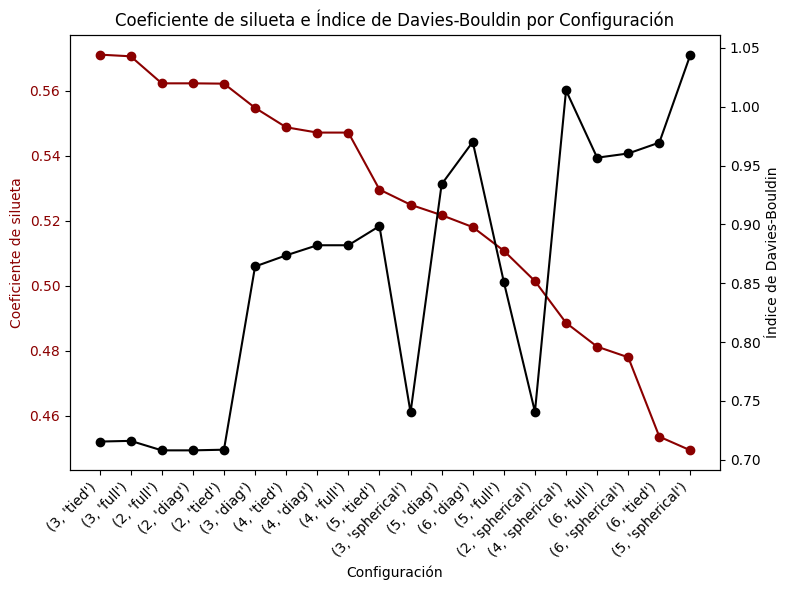

In [16]:
n_components_values = [2, 3, 4, 5, 6]
covariance_type_values = ['full', 'tied', 'diag', 'spherical']

param_grid_gaussian = [
    (n_components, covariance_type)
    for n_components in n_components_values
    for covariance_type in covariance_type_values
]

resultados_gaussian = evaluar_agrupamiento(df, GaussianMixture, param_grid_gaussian, metodo='silhouette')
display(resultados_gaussian)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
1,"(0.5,)",0.600974,0.237940
0,"(None,)",0.572036,0.706287
5,"(4,)",0.548598,0.869308
4,"(3,)",0.512265,1.075235
3,"(2,)",0.406740,1.222793
2,"(1,)",0.181732,1.007411


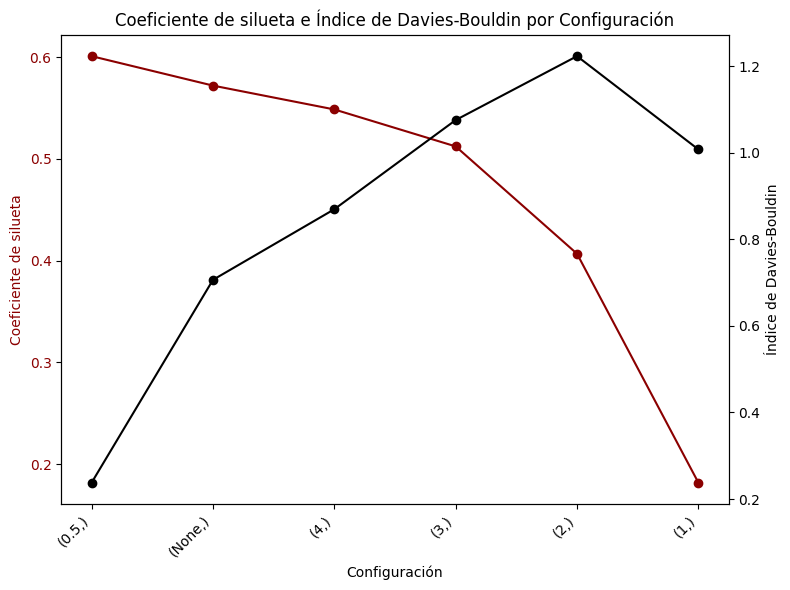

In [21]:
bandwidth_values = [(value,) for value in [None, 0.5, 1, 2, 3, 4]]
resultados_meanshift = evaluar_agrupamiento(df, MeanShift, bandwidth_values, metodo='silhouette')
display(resultados_meanshift)

In [71]:
# Ajustar la cantidad de varianza acumulada por explicar
varianza_objetivo = 0.9

# Realizar el análisis de componentes principales
pca = PCA()
componentes_principales = pca.fit_transform(df[columnas_numericas])

# Encontrar la cantidad de componentes necesarias para explicar al menos la varianza objetivo
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
n_componentes_seleccionadas = np.argmax(varianza_acumulada >= varianza_objetivo) + 1

# Ajustar el PCA con la cantidad óptima de componentes
pca = PCA(n_components=n_componentes_seleccionadas)
componentes_principales = pca.fit_transform(df[columnas_numericas])

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(data=componentes_principales,
    columns=[f'PC{i+1}' for i in range(n_componentes_seleccionadas)])

# Combinar con el DataFrame original
pca_df = pd.concat([df, pca_df], axis=1)

display(pca_df)

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,ReceivingNumR,StateOpeR,StateResR,MunOpeR,MunResR,CountryR,PC1,PC2,PC3,PC4
0,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.80,0.9,0.8,1.00,0.90,1.0,2.770057,0.352892,-0.411844,-0.429982
1,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.80,0.9,0.8,1.00,0.90,1.0,2.936999,0.330770,-0.441063,-0.477342
2,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.80,0.9,0.8,1.00,0.90,1.0,2.995240,0.320920,-0.467807,-0.526095
3,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.80,0.9,0.8,1.00,0.90,1.0,2.989043,0.321864,-0.516347,-0.439808
4,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.80,0.9,0.8,1.00,0.90,1.0,2.834694,0.308897,-0.460650,-0.484967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.20,0.2,0.2,0.15,0.05,0.1,-1.097155,0.173608,0.022412,-0.070916
26747,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.3,0.1,0.15,0.05,0.1,-1.098019,0.148704,-0.024189,-0.035866
26748,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.2,0.2,0.15,0.05,0.1,-1.063077,0.138360,-0.044507,-0.027013
26749,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.3,0.2,0.15,0.05,0.1,-1.106338,0.186773,0.033121,-0.125489


In [72]:
# Cálculo del indicador de anomalía
indicator = np.sum(np.dot(pca_df.iloc[:, :-n_componentes_seleccionadas], np.square(pca.components_).T * pca.explained_variance_), axis=1) / np.sum(pca.explained_variance_)
print(indicator)

[0.90051844 0.9249805  0.93363148 ... 0.15172793 0.14661956 0.1529953 ]


In [75]:
print(indicator[:20])

[0.90051844 0.9249805  0.93363148 0.93259064 0.90945588 0.90975313
 0.93303595 0.93449189 0.91780774 0.9081008  0.90345597 0.91113006
 0.90784863 0.91862055 0.92001886 0.91135128 0.92480791 0.91085613
 0.92068435 0.90050509]


In [82]:
print(pca_df['es_atipico'].value_counts())

es_atipico
False    23159
True      3592
Name: count, dtype: int64


In [76]:
# Establecer el umbral para definir clientes anómalos
umbral = 0.7

# Seleccionar los clientes anómalos
pca_df['es_atipico'] = indicator > umbral

display(pca_df.head(20))

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,StateOpeR,StateResR,MunOpeR,MunResR,CountryR,PC1,PC2,PC3,PC4,es_atipico
0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,0.75,...,0.9,0.8,1.0,0.9,1.0,2.770057,0.352892,-0.411844,-0.429982,True
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,0.75,...,0.9,0.8,1.0,0.9,1.0,2.936999,0.330770,-0.441063,-0.477342,True
2,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.995240,0.320920,-0.467807,-0.526095,True
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.989043,0.321864,-0.516347,-0.439808,True
4,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.834694,0.308897,-0.460650,-0.484967,True
5,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.836556,0.322928,-0.447852,-0.512587,True
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.991076,0.321583,-0.513930,-0.439383,True
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.996195,0.325657,-0.488113,-0.491158,True
8,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,0.75,...,0.9,0.8,1.0,0.9,1.0,2.885656,0.321007,-0.472139,-0.363005,True
9,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.00,...,0.9,0.8,1.0,0.9,1.0,2.817325,0.356456,-0.416391,-0.524120,True


<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

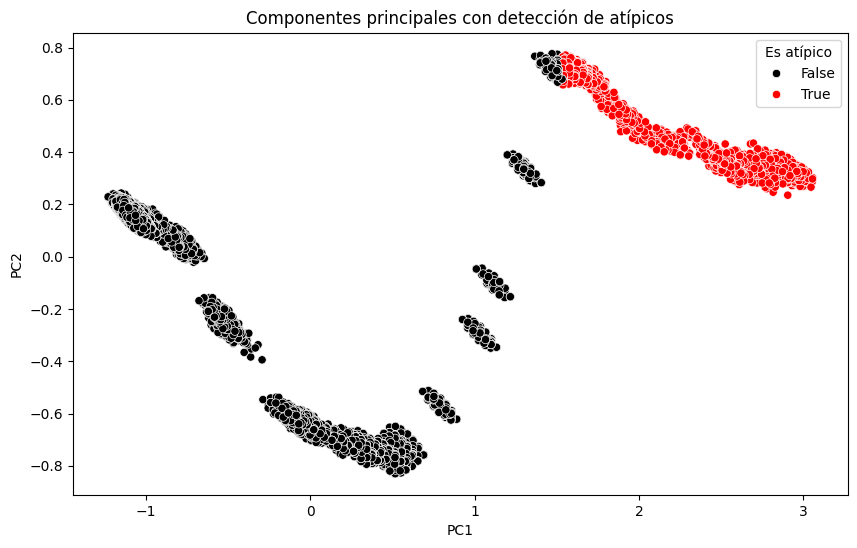

In [83]:
# Visualización de las componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='es_atipico', palette=['black', 'red'])
plt.title('Componentes principales con detección de atípicos')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Es atípico')
display(plt)

In [ ]:
# Número total de transacciones
num_transacciones = df.shape[0]

# Número de transacciones atípicas
porcentaje_atipicas = (num_atipicas / num_transacciones) * 100

# Métricas clave del indicador de anomalía
min_indicador = np.min(indicador_anomalia)
max_indicador = np.max(indicador_anomalia)
media_indicador = np.mean(indicador_anomalia)

# Mostrar los resultados
print(f"Número total de transacciones: {num_transacciones}")
print(f"Número de transacciones atípicas: {num_atipicas}")
print(f"Porcentaje de transacciones atípicas: {porcentaje_atipicas:.2f}%")
print(f"Métrica mínima del indicador: {min_indicador:.4f}")
print(f"Métrica máxima del indicador: {max_indicador:.4f}")
print(f"Promedio del indicador de anomalía: {media_indicador:.4f}")

In [31]:
# Exportar resultados
pca_df.to_csv('../data/resultado_pca.csv', index=False)
print("Resultados exportados a 'resultado_pca.csv'")

Resultados exportados a 'resultado_pca.csv'
